In [1]:
import sys; sys.path.append('..')

import torch
from torchvision.transforms import transforms, functional as F
from PIL import Image

from models.bisenet import BiSeNet
from models.fran import FRAN

In [2]:
im = Image.open('floris2.jpg')
im = im.resize((1024, 1024))

In [3]:
bisenet = BiSeNet(n_classes=19)
bisenet.load_state_dict(torch.load('../pretrained_models/bisenet_79999_iter.pth'))
bisenet.eval().cuda();

tfm_bise = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

bise_input = tfm_bise(im)[None, ...].cuda()

with torch.no_grad():
    bise_output = bisenet(bise_input)[0][0].argmax(0).cpu().numpy()

In [4]:
import numpy as np

mask = ~np.isin(bise_output, [0, 16, 17])
mask_im = Image.fromarray((mask * 255).astype(np.uint8)).resize((1024, 1024))
mask = np.array(mask_im) / 255

In [5]:
fran = FRAN()
state_dicts = torch.load('../ckpts/doe6za4i_ep12.pth')
fran.load_state_dict(state_dicts['FRAN'])
fran.eval().cuda();

In [6]:
ccrop_size = (1024, 1024)
tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop(ccrop_size),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
inv_norm = transforms.Normalize([-1, -1, -1.], [2, 2, 2.])

In [7]:
t = tfm(im)[None, ...].cuda()

src_age = 29
tgt_ages = [80]

reaged_ims = []

for tgt_age in tgt_ages:
    src_age_map = torch.ones((1024, 1024)) * src_age
    tgt_age_map = torch.tensor((mask * (tgt_age - src_age)) + src_age).float()
    src_age_map = F.center_crop(src_age_map[None, None, ...], ccrop_size).cuda()
    tgt_age_map = F.center_crop(tgt_age_map[None, None, ...], ccrop_size).cuda()
    
    with torch.no_grad():
        out = fran(t, src_age_map, tgt_age_map)[0].cpu()
    
    im = F.to_pil_image(inv_norm(out).clip(min=0, max=1)).resize((512, 512))
    reaged_ims.append(im)

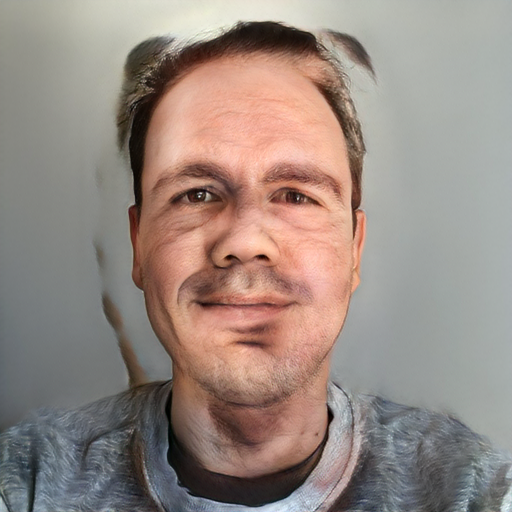

In [8]:
Image.fromarray(np.concatenate(reaged_ims, axis=1))